In [1]:
# The MIT License (MIT) Copyright (c) 2024 Andrés Urbano Andrea, Núñez Quintana Luis Axel & Ramírez Gómez María Emilia
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in the Software without
# restriction, including without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Andrea585976/ArtEmis-ProyectoPLN/blob/main/models/artemis_transformers_pretrained.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Image Captioning Transformer


- This notebook explores the combination of Transformers and CNNs for image captioning, showcasing their remarkable ability to generate descriptive textual captions based on visual content.

## 0. Dependencias

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import PIL
from PIL import Image
import random
import time
import torch
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as Vocab
import torchvision
from torchvision.models import efficientnet_b0
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torchvision import transforms

torch.__version__

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

'2.3.0+cu121'

In [3]:
torch.manual_seed(77)

## 1.- Dataset

In [4]:
# Download dataset
if not os.path.exists('img'):
  !wget https://github.com/Andrea585976/ArtEmis-ProyectoPLN/raw/main/img.zip
  !unzip img.zip
  !rm img.zip
if not os.path.exists('romanticism_dataset.csv'):
  !wget https://raw.githubusercontent.com/Andrea585976/ArtEmis-ProyectoPLN/main/romanticism_dataset.csv


Streaming output truncated to the last 5000 lines.
  inflating: img/nikolai-ge_love-of-vestal.jpg  
  inflating: img/camille-corot_orpheus-leading-eurydice-from-the-underworld-1861.jpg  
  inflating: img/caspar-david-friedrich_easter-morning.jpg  
  inflating: img/konstantin-makovsky_beauty-preparing-to-bathe.jpg  
  inflating: img/john-everett-millais_the-royalist.jpg  
  inflating: img/pierre-paul-prud'hon_madame-simon.jpg  
  inflating: img/konstantin-makovsky_portrait-of-the-count-nikolay-muravyov-amursky.jpg  
  inflating: img/jean-leon-gerome_pifferari2.jpg  
  inflating: img/gustave-dore_daniel-confounds-the-priests-of-bel.jpg  
  inflating: img/john-crome_carrow-abbey-norwich-1805.jpg  
  inflating: img/nikolai-ge_death-of-virginia-study-1.jpg  
  inflating: img/gustave-dore_the-inferno-canto-32-1.jpg  
  inflating: img/john-constable_shoreham-bay-near-brighton-1824.jpg  
  inflating: img/william-turner_view-of-saint-germain-ea-laye-and-its-chateau.jpg  
  inflating: img/ivan-a

In [5]:
# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv('romanticism_dataset.csv')
print(df.columns)

images = df.loc[:, ['painting', 'utterance']]
images['painting'] = images['painting'].apply(lambda x: 'img/' + x + '.jpg')

images.head(10)

Index(['painting', 'emotion', 'utterance', 'repetition'], dtype='object')


,painting,utterance
0,img/viktor-vasnetsov_ivan-tsarevich-riding-the...,The scene is quite beautiful and reminds me of...
1,img/viktor-vasnetsov_ivan-tsarevich-riding-the...,There is a sense of romance between the two pe...
2,img/william-turner_fishermen-at-sea.jpg,"There is a spooky feel to this image, with the..."
3,img/william-turner_fishermen-at-sea.jpg,The boat makes a dangerous journey alone at ni...
4,img/paul-cezanne_the-oilmill-1871.jpg,The village looks very rudimentary with it's s...
5,img/n.c.-wyeth_merlin-taking-away-the-infant-a...,It looks like the baby is being taken for what...
6,img/orest-kiprensky_the-family-of-satyrs.jpg,The imps playfully dance and sing to the music.
7,img/sir-lawrence-alma-tadema_strigils-and-spon...,The women appear quite interested in one anoth...
8,img/orest-kiprensky_putto-with-a-globe.jpg,The little boy is trying to roll the globe aro...
9,img/sir-lawrence-alma-tadema_pleading-1876.jpg,The man laying down in this painting feels lik...


- Download images:

In [6]:
# Convertir df_subset en un arreglo NumPy sin nombres de columnas
images = images.values
images = sorted(images, key = lambda x: x[0])
len(images)

39069

- Dataset split

In [7]:
# split is made so that train and val dont have the same painting
num_val_samples = int(0.05 * len(images)) + 2
train_images = images[num_val_samples:]
val_images= images[:num_val_samples]
print(train_images[:1],val_images[-1:])
print(len(train_images), len(val_images))

[array(['img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg',
       'This is interesting because did the maiden find the child and return to the queen or did the queen just deliver while they were on a ride. Very interesting'],
      dtype=object)] [array(['img/arthur-hughes_the-beautiful-lady-without-pity-1863.jpg',
       'The look of two people in love.'], dtype=object)]
37114 1955


In [8]:
def generate_tuples(paths):
    tuples = []
    for image_path, text in paths:
        if os.path.exists(image_path):  # Verificar si la imagen existe en la ruta
            tuples.append((image_path, text.strip()))
    return tuples

train_tuples = generate_tuples(train_images)
val_tuples = generate_tuples(val_images)

len(train_tuples), len(val_tuples)

(36910, 1851)

In [9]:
for tuple in train_tuples[:2]:
    print(tuple)

('img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg', 'This is interesting because did the maiden find the child and return to the queen or did the queen just deliver while they were on a ride. Very interesting')
('img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg', 'The mother face looks excited to hold her baby for the first time')


## 2.- Pipeline

- Create vocabulary and tokenizer.

In [10]:
tokenizer = get_tokenizer('basic_english')

In [11]:
def build_vocab(text, tokenizer):
    counter = Counter()
    for _, string_ in text:
        counter.update(tokenizer(string_))
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])


vocab = build_vocab(train_tuples, tokenizer)
vocab.set_default_index(0) # fix <ukn>

In [12]:
vocab_size = len(vocab)
vocab_size

16820

In [13]:
image_size = 128
batch_size = 64
maxlen = 36

PAD_IDX = vocab['<pad>']
BOS_IDX = vocab['<bos>']
EOS_IDX = vocab['<eos>']
PAD_IDX, BOS_IDX, EOS_IDX

(1, 2, 3)

- Reduce dataset size for simplicity

In [14]:
def data_process(text):
    data = []
    for x, y in text:
        tensor_ = torch.tensor(
            [vocab[token] for token in tokenizer(y)],
            dtype=torch.long
        )

        if tensor_.shape[0] < maxlen:
            data.append((x, tensor_))

    return data

train_data = data_process(train_tuples[:50000])
val_data = data_process(val_tuples[:1000])
len(train_data), len(val_data)

(35389, 961)

In [15]:
transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
])

def generate_batch(data_batch):
    x, y = [], []
    for (x_item, y_item) in data_batch:
        image = Image.open(x_item).convert('RGB')
        image = transform(image)
        x.append(image)
        y.append(
            torch.cat([
                torch.tensor([BOS_IDX]),
                y_item,
                torch.tensor([EOS_IDX])
            ], dim=0)
        )

    x = torch.stack(x)
    y = pad_sequence(y, batch_first=True, padding_value=PAD_IDX)
    return x, y[:, :-1], y[:, 1:]

train_loader = DataLoader(train_data, batch_size=batch_size,
                    shuffle=True, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                    shuffle=False, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
enc_batch, dec_batch, target_batch = next(iter(val_loader))
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 31]), torch.Size([64, 31]))

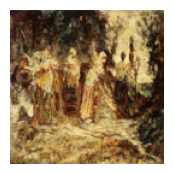

Ground truth: the bright colors and splashes of reds give this piece an energetic look , like the maidens in it are about to <unk> on a journey .    


In [18]:
def plot_img(img, target):
    image_array = img.permute(1, 2, 0).numpy()
    image_text = " ".join(
        [vocab.get_itos()[_] for _ in target]
    ).replace("<pad>", "").replace("<eos>", "")

    fig = plt.figure(figsize=(2, 2))

    # Plot the image
    plt.imshow(image_array)
    #plt.title(image_text)
    plt.axis('off')  # Optional: Turn off axes
    plt.show()
    print(f'Ground truth: {image_text}')

idx = 10
plot_img(enc_batch[idx], target_batch[idx])

## 3.- Model

### Feature extraction block
- Define a convolutional network for image feature extraction.

In [20]:
# MaskRCNN requires a backbone with an attached FPN
class Pretrained(torch.nn.Module):
    def __init__(self):
        super(Pretrained, self).__init__()
        m = efficientnet_b0()
        self.body = create_feature_extractor(
            m, return_nodes={'features.5.0.block.0':'0'})
        inp = torch.randn(1, 3, 128, 128)
        with torch.no_grad():
            out = self.body(inp)
        in_channels_list = [o.shape[1] for o in out.values()]
        self.out_channels = 256
        self.fpn = FeaturePyramidNetwork(
            in_channels_list, out_channels=self.out_channels,
            extra_blocks=LastLevelMaxPool())

    def forward(self, x):
        x = self.body(x)

        return x['0']

model = Pretrained().eval()
model(enc_batch).shape

torch.Size([64, 480, 8, 8])

In [21]:
class CNN(nn.Module):
    def __init__(self, filters=128, noise_dim=64):
        super(CNN, self).__init__()
        self.filters = filters
        self.pretrained = Pretrained().eval()
        self.adapt = nn.Sequential(
            nn.Conv2d(480, 29, 3, bias=False, padding = 1, stride = 1)
        )

    def forward(self, x):
        B = x.shape[0]
        y = self.pretrained(x)
        y = self.adapt(y)
        y = y.reshape(B, 64, 29).permute(0, 2, 1)
        return y


discriminator = CNN(256)
out_disc = discriminator(enc_batch)
out_disc.shape

torch.Size([64, 29, 64])

### Transformer block

In [22]:
class Attention(nn.Module):
    def __init__(self, dim, maxlen, n_heads=4, bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -0.5
        self.wq = nn.Linear(dim, dim, bias = bias)
        self.wk = nn.Linear(dim, dim, bias = bias)
        self.wv = nn.Linear(dim, dim, bias = bias)

        self.wo = nn.Linear(dim, dim, bias = bias)
        self.register_buffer("bias", torch.tril(torch.ones(maxlen, maxlen)).view(1, 1, maxlen, maxlen))

    def forward(self, x, context=None):
        B, L, D = x.shape
        out_L = L
        q = self.wq(x)
        q = torch.reshape(q, [B, L, self.n_heads, -1])
        q = torch.permute(q, [0, 2, 1, 3])

        if context == None:
            k = self.wk(x)
            v = self.wv(x)
        else:
            k = self.wk(context)
            v = self.wv(context)
            B, L, D = k.shape

        k = torch.reshape(k, [B, L, self.n_heads, -1])
        k = torch.permute(k, [0, 2, 3, 1])
        v = torch.reshape(v, [B, L, self.n_heads, -1])
        v = torch.permute(v, [0, 2, 1, 3])

        qk = torch.matmul(q, k) * self.scale
        if context == None:
            qk = qk.masked_fill(self.bias[:,:,:L,:L] == 0, float('-inf'))

        attn = torch.softmax(qk, dim=-1)

        v_attn = torch.matmul(attn, v)
        v_attn = torch.permute(v_attn, [0, 2, 1, 3])
        v_attn = torch.reshape(v_attn, [B, out_L, D])

        x = self.wo(v_attn)
        return x


q_test = torch.ones([1, 8, 32])
k_test = torch.ones([1, 64, 32])
test_layer = Attention(32, maxlen, n_heads=4)
test_layer(q_test).shape, test_layer(q_test, k_test).shape

(torch.Size([1, 8, 32]), torch.Size([1, 8, 32]))

- Define Transformer:

In [23]:
class DecoderBlock(nn.Module):
    def __init__(self, dim, maxlen, heads=4, mlp_dim=512, rate=0.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, maxlen)
        self.cross_attn = Attention(dim, maxlen)
        self.ln_2 = nn.LayerNorm(dim)
        self.ln_3 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(rate),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(rate),
        )

    def forward(self, x):
        inputs, context = x
        x = self.attn(inputs)
        skip1 = self.ln_1(x + inputs)
        x = self.cross_attn(skip1, context)
        skip2 = self.ln_2(x + skip1)
        return self.ln_3(self.mlp(skip2) + skip2)


test_layer = DecoderBlock(32, maxlen)
x_test = torch.ones([1, maxlen, 32])
test_layer([x_test, x_test]).shape

torch.Size([1, 36, 32])

- Define Transformer

In [24]:
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 31]), torch.Size([64, 31]))

### Transformer

In [25]:
class Transformer(nn.Module):
    def __init__(self, dim, vocab_size, maxlen, depth=3,
                 mlp_dim=512, rate=0.2):
        super().__init__()
        self.depth = depth
        self.embedding = nn.Embedding(vocab_size, dim)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, maxlen, dim))

        self.decoder = nn.ModuleList()
        for i in range(self.depth):
            self.decoder.append(DecoderBlock(dim, maxlen))

        self.head = nn.Linear(dim, vocab_size, bias=False)
        self.cnn = CNN(dim)

    def forward(self, x, context):
        B, L = x.shape
        x = self.embedding(x)
        x += self.pos_embedding[:, :L]

        context = self.cnn(context)
        for layer in self.decoder:
            x = layer([x, context])
        x = self.head(x)
        return x


model_dim = 64
mlp_dim = 128
depth = 3

transformer = Transformer(dim=model_dim, vocab_size=vocab_size,
          maxlen=maxlen, depth=depth, mlp_dim=mlp_dim)
output = transformer(dec_batch, enc_batch)
output.shape, target_batch.shape

(torch.Size([64, 31, 16820]), torch.Size([64, 31]))

## 4.- Training

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

transformer.to(device)

cuda:0


Transformer(
  (embedding): Embedding(16820, 64)
  (decoder): ModuleList(
    (0-2): 3 x DecoderBlock(
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (wq): Linear(in_features=64, out_features=64, bias=True)
        (wk): Linear(in_features=64, out_features=64, bias=True)
        (wv): Linear(in_features=64, out_features=64, bias=True)
        (wo): Linear(in_features=64, out_features=64, bias=True)
      )
      (cross_attn): Attention(
        (wq): Linear(in_features=64, out_features=64, bias=True)
        (wk): Linear(in_features=64, out_features=64, bias=True)
        (wv): Linear(in_features=64, out_features=64, bias=True)
        (wo): Linear(in_features=64, out_features=64, bias=True)
      )
      (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=512, bias=True)
        (1): G

In [27]:
optimizer = optim.Adam(transformer.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [28]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inp_enc, inp_dec, tar_dec in train_loader:
        tar_dec = tar_dec.reshape(-1)
        inp_enc = inp_enc.to(device)
        inp_dec = inp_dec.to(device)
        tar_dec = tar_dec.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inp_dec, inp_enc)
        outputs = outputs.view(-1, outputs.size(-1))
        loss = loss_fn(outputs, tar_dec)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [29]:
def generate(model, image, device, maxlen):
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        model.eval()
        idx = torch.tensor(BOS_IDX, dtype=torch.long)
        idx = idx.reshape([1, -1])

        for _ in range(maxlen):
            idx = idx.to(device)
            logits = model(idx, image)[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

            _, idx_next = torch.topk(probs, k=1, dim=-1)
            if vocab.get_itos()[idx_next] == '<eos>':
                break
            idx = torch.cat((idx, idx_next), dim=1)

    txt = " ".join(
        [vocab.get_itos()[_] for _ in idx[0]]
    )
    print(f'Generated text: {txt.replace("<bos>", "")}')


generate(transformer, enc_batch[idx], device, maxlen)

Generated text:  stroking re-assuring digest emits left seamlessly subject well-traversed moreso smugly achies advanced respite bode nursery shininess dehydration hues implement taut argue philosophical web log enlightened enemy trampled boredom feed condemning laughed nuzzling grass erotically furry mega


In [44]:
epochs = 25

for epoch in range(epochs):
  train(transformer, device, train_loader, optimizer, epoch)
  generate(transformer, enc_batch[idx], device, maxlen)


Time for epoch 0 is 192.5856 sec Train loss: 3.3741
Generated text:  the people look like they are in pain and the people are in a dark forest .

Time for epoch 1 is 193.4269 sec Train loss: 3.3024
Generated text:  the woman is lying on the ground , and the people are all alone .

Time for epoch 2 is 187.4825 sec Train loss: 3.2426
Generated text:  the scene is very dark and the colors are very bright and the people look like they are in danger .

Time for epoch 3 is 186.2517 sec Train loss: 3.1887
Generated text:  the woman is lying on the ground , and the man on the ground is being held by the horse .

Time for epoch 4 is 185.4858 sec Train loss: 3.1359
Generated text:  the scene is quite lovely and i appreciate the way the light is warmed .

Time for epoch 5 is 186.1204 sec Train loss: 3.0876
Generated text:  the people are being led to the man in the middle of the crowd

Time for epoch 6 is 187.9336 sec Train loss: 3.0425
Generated text:  the people are having a good time with eac

- Test the model on validation images.

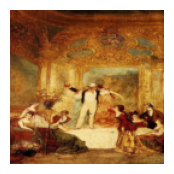

Ground truth: it appears to be a brothel . two women hanging on one man , dressed well , spending his money to have his way with them .    
Generated text:  the man is playing a loved one another and who he is holding a dead body cloth


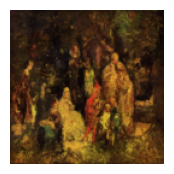

Ground truth: the dark colors , the postures of the figures , and the body gestures toward one another <unk> a feeling they are in a sad mood .    
Generated text:  the people in the painting look like they are having a good time .


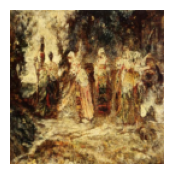

Ground truth: the bright colors and splashes of reds give this piece an energetic look , like the maidens in it are about to <unk> on a journey .    
Generated text:  the women are having a hard time with each other and the colors in the background .


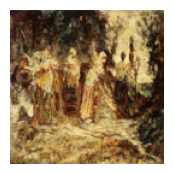

Ground truth: its a little scary with how grainy it is , there is something haunting about it like the scary stories to tell in the dark style artwork .   
Generated text:  the people in the painting look like they are having a good time .


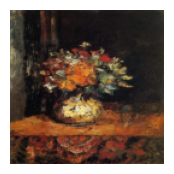

Ground truth: the colors are dark and dreary . also , the bouquet reminds me of funeral flowers .              
Generated text:  the woman is holding a knife her head


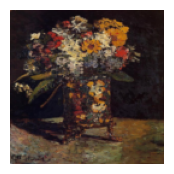

Ground truth: the vase going for a walk                         
Generated text:  the people in the painting look like they are in a bad place


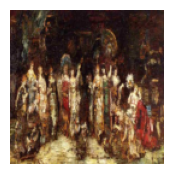

Ground truth: this is a very traditional composition , but the painting effects make it interesting to me               
Generated text:  the people in the painting look like they are having a good time .


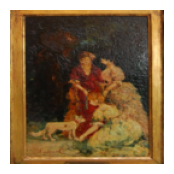

Ground truth: i ' m amused because im very interested to find out whats really <unk> in the picture .             
Generated text:  the man is holding a dead body , and the man is wearing red


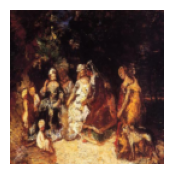

Ground truth: there is a <unk> , like people have just discovered a dark secret around the campfire . their expressions are jagged , like the paint strokes applied    
Generated text:  the man in the middle looks like he is going on the glass .


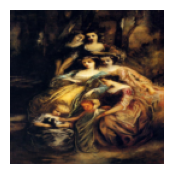

Ground truth: women of various ages seeming to drown in their <unk> .                    
Generated text:  the woman is holding a knife her head


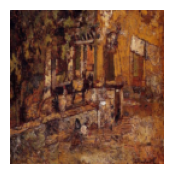

Ground truth: the scene is of a simple <unk> house . the colors are warm . the place looks inviting , sincere , and comforting .       
Generated text:  the people in the painting look like they are having a good time .


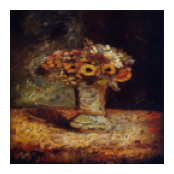

Ground truth: flowers are usually given because something happens                        
Generated text:  the man is spanking the woman in the corner of the room .


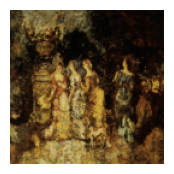

Ground truth: all of the women appear to have little to no expression on their faces .                
Generated text:  the people in the painting look like they are having a good time .


In [45]:
for i in range(0, 64, 5):
  idx = i
  plot_img(enc_batch[idx], target_batch[idx])
  generate(transformer, enc_batch[idx], device, maxlen)